# PyTorch CNN model

In this notebook, we build a convolutional neural network (CNN) classifier for the CIFAR-10 dataset using PyTorch's `nn.Sequential` module.

## Notebook set-up

### Imports

In [1]:
# Standard library imports
import pickle
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Package imports
from image_classification_tools.pytorch.data import (
    load_dataset, prepare_splits, create_dataloaders
)
from image_classification_tools.pytorch.evaluation import evaluate_model
from image_classification_tools.pytorch.plotting import (
    plot_sample_images, plot_learning_curves, 
    plot_confusion_matrix, plot_class_probability_distributions,
    plot_evaluation_curves
)

from image_classification_tools.pytorch.training import train_model

### Configuration

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Path to the CIFAR-10 dataset
data_dir = Path('../data/pytorch/cifar10')

# CIFAR-10 class names in class order
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

num_classes = len(class_names)

Using device: cuda:1


### Hyperparameters

In [3]:
validation_size = 10000
batch_size = 64
learning_rate = 1e-3
epochs = 150
print_every = 25 # Print training progress every n epochs

## 1. Load and preprocess CIFAR-10 data

CIFAR-10 contains 32x32 color images (3 channels) across 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

### 1.1. Visualize sample images

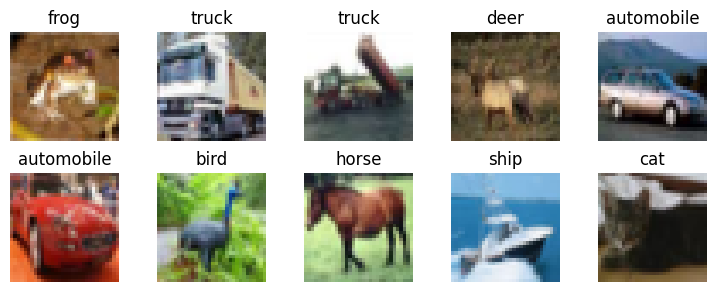

In [4]:
# Get a sample dataset for visualization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
sample_dataset = datasets.CIFAR10(root=data_dir, transform=transform)
                                    
# Plot first 10 images from the training dataset
fig, axes = plot_sample_images(sample_dataset, class_names)
plt.show()

### 1.2. Define preprocessing transform

In [5]:
# Define basic input transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # Convert images to grayscale
    transforms.ToTensor(),                       # Transform images to tensors   
    transforms.Normalize((0.5,), (0.5,)),        # Normalize the images
])

### 1.3. Load the training and testing datasets from disk

In [6]:
# Step 1: Load datasets
train_dataset = load_dataset(
    data_source=datasets.CIFAR10,
    transform=transform,
    root=data_dir,
    train=True
)

test_dataset = load_dataset(
    data_source=datasets.CIFAR10,
    transform=transform,
    root=data_dir,
    train=False
)

### 1.4. Make training, validation split

In [7]:
train_dataset, val_dataset, test_dataset = prepare_splits(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    val_size=validation_size
)

### 1.5. Create dataloaders

In [8]:
# Step 3: Create DataLoaders
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset,
    batch_size=batch_size,
    preload_to_memory=True,
    device=device
)

print(f'Training batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')

Training batches: 625
Validation batches: 157
Test batches: 157


## 2. Build CNN classifier with nn.Sequential

We build a convolutional neural network using `nn.Sequential`. The CNN uses convolutional layers to extract spatial features from the 32x32x1 grayscale images before classification.

### 2.1. Define model architecture

In [9]:
# Input: 1 x 32 x 32 (grayscale)
model = nn.Sequential(

    # Conv block 1: 1 -> 32 channels, 32x32 -> 16x16
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.25),
    
    # Classifier
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(32, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes)

).to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f'\nTotal parameters: {trainable_params}')

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.25, inplace=False)
  (8): AdaptiveAvgPool2d(output_size=(1, 1))
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=32, out_features=128, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=128, out_features=10, bias=True)
)

Total parameters: 15210


### 2.2. Define loss function and optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### 2.3. Train model

In [11]:
%%time

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    print_every=print_every
)

print()

Epoch   1/150 - loss: 1.8900 - acc: 29.50% - val_loss: 1.6878 - val_acc: 37.98%
Epoch  25/150 - loss: 1.3132 - acc: 53.53% - val_loss: 1.3273 - val_acc: 53.41%
Epoch  50/150 - loss: 1.2163 - acc: 57.14% - val_loss: 1.2586 - val_acc: 55.00%
Epoch  75/150 - loss: 1.1661 - acc: 58.95% - val_loss: 1.1987 - val_acc: 56.80%
Epoch 100/150 - loss: 1.1229 - acc: 60.16% - val_loss: 1.0877 - val_acc: 61.35%
Epoch 125/150 - loss: 1.0870 - acc: 61.71% - val_loss: 1.1479 - val_acc: 59.86%
Epoch 150/150 - loss: 1.0720 - acc: 62.18% - val_loss: 1.0501 - val_acc: 63.00%

CPU times: user 13min 54s, sys: 3.67 s, total: 13min 57s
Wall time: 13min 47s


### 2.5. Learning curves

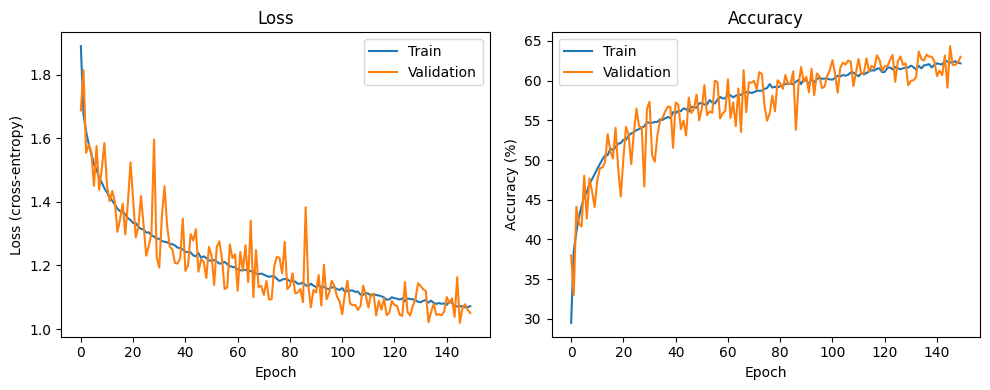

In [12]:
fig, axes = plot_learning_curves(history)
plt.show()

## 3. Evaluate model on test set

### 3.1. Calculate test accuracy

In [13]:
test_accuracy, predictions, true_labels = evaluate_model(model, test_loader)
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 62.99%


### 3.2. Per-class accuracy

In [14]:
# Calculate per-class accuracy
class_correct = {name: 0 for name in class_names}
class_total = {name: 0 for name in class_names}

for pred, true in zip(predictions, true_labels):

    class_name = class_names[true]
    class_total[class_name] += 1

    if pred == true:
        class_correct[class_name] += 1

print('Per-class accuracy:')
print('-' * 30)

for name in class_names:
    acc = 100 * class_correct[name] / class_total[name]
    print(f'{name:12s}: {acc:.2f}%')

Per-class accuracy:
------------------------------
airplane    : 66.80%
automobile  : 74.90%
bird        : 48.00%
cat         : 33.30%
deer        : 50.30%
dog         : 62.80%
frog        : 71.00%
horse       : 58.60%
ship        : 79.20%
truck       : 85.00%


### 3.4. Confusion matrix

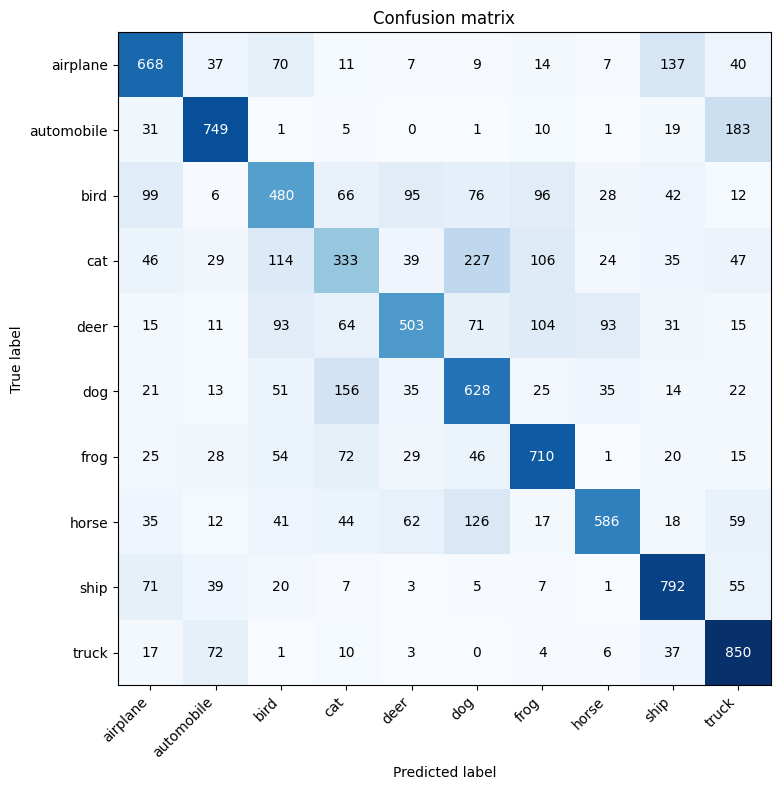

In [15]:
fig, ax = plot_confusion_matrix(true_labels, predictions, class_names)
plt.show()

### 3.5. Predicted class probability distributions

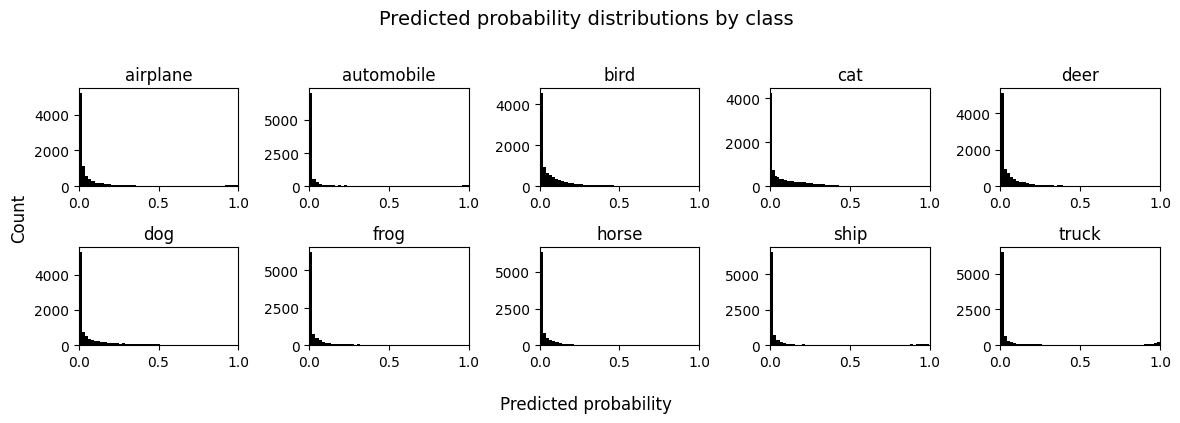

In [16]:
# Get predicted probabilities for all test samples
model.eval()
all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)

# Plot probability distributions
fig, axes = plot_class_probability_distributions(all_probs, class_names)
plt.show()

### 3.6. Evaluation curves

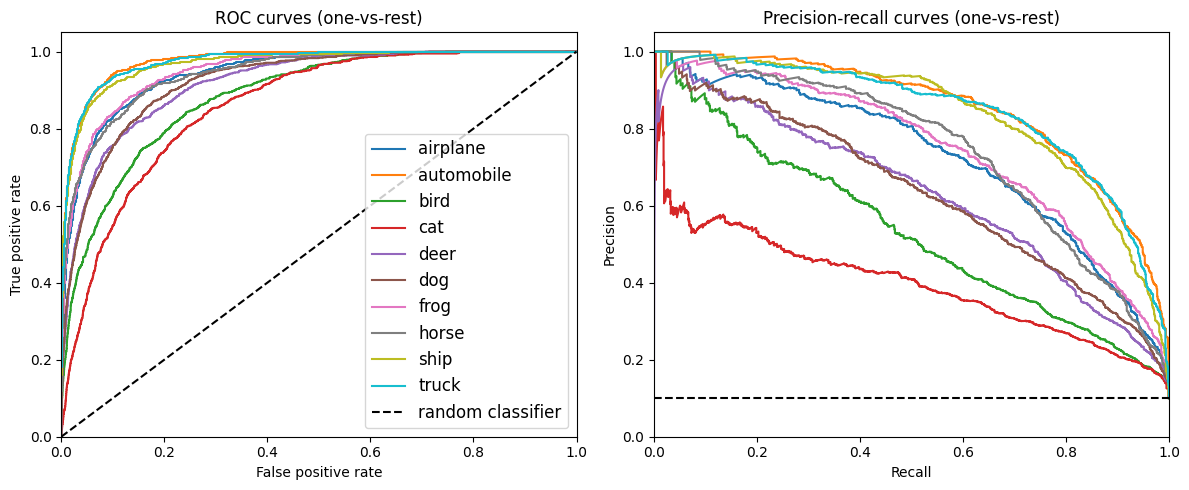

In [17]:
fig, (ax1, ax2) = plot_evaluation_curves(true_labels, all_probs, class_names)
plt.show()

## 4. Save model

In [18]:
# Create models directory if it doesn't exist
models_dir = Path('../models/pytorch')
models_dir.mkdir(parents=True, exist_ok=True)

# Save model state dict
model_path = models_dir / 'cnn.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'test_accuracy': test_accuracy,
    'history': history
}, model_path)

print(f'Model saved to: {model_path}')
print(f'Test accuracy: {test_accuracy:.2f}%')

Model saved to: ../models/pytorch/cnn.pth
Test accuracy: 62.99%


## 5. Save test results for comparison

In [19]:
# Create results directory
models_dir = Path('../data/pytorch/performance_results')
models_dir.mkdir(parents=True, exist_ok=True)
results_path = models_dir / 'cnn_results.pkl'

# Count model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Create results dictionary
results_dict = {
    'true_labels': true_labels,
    'predictions': predictions,
    'all_probs': all_probs,
    'test_accuracy': test_accuracy,
    'total_params': total_params,
    'trainable_params': trainable_params
}

# Save results
with open(results_path, 'wb') as f:
    pickle.dump(results_dict, f)

print(f'Test results saved to: {results_path}')

print(f'  - Test accuracy: {test_accuracy:.2f}%')
print(f'  - Trainable parameters: {trainable_params:,}')
print(f'  - Total parameters: {total_params:,}')

Test results saved to: ../data/pytorch/performance_results/cnn_results.pkl
  - Test accuracy: 62.99%
  - Trainable parameters: 15,210
  - Total parameters: 15,210
